# Importar bibliotecas:

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > /dev/null
!pip install scikit-learn --upgrade

import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport
import os

from multiprocessing.pool import Pool
from math import radians,degrees
from typing import Tuple
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics.pairwise import haversine_distances
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.utils._testing import ignore_warnings
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# Upload do Dataset (CSV):

In [2]:
uber_df = pd.read_csv('uber_peru_2010.csv', delimiter=';')
uber_df.columns

Index(['journey_id', 'user_id', 'driver_id', 'taxi_id', 'icon', 'start_type',
       'start_at', 'start_lat', 'start_lon', 'end_at', 'end_lat', 'end_lon',
       'end_state', 'driver_start_lat', 'driver_start_lon', 'arrived_at',
       'currency', 'price', 'price_distance', 'price_duration', 'distance',
       'duration', 'cost', 'cost_distance', 'cost_duration', 'source',
       'driver_score', 'rider_score'],
      dtype='object')

# Análise exploratória:

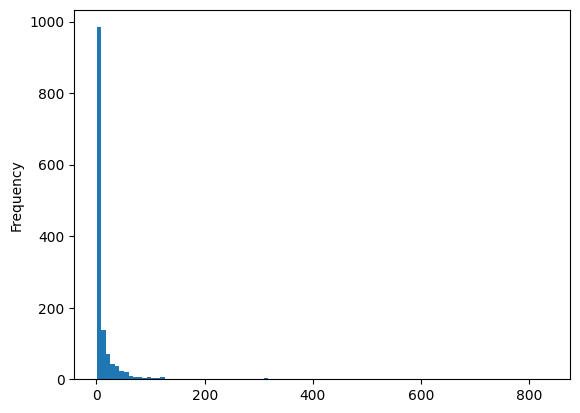

In [11]:
# Descrição e insight dos dados:
uber_df = uber_df[['journey_id', 'user_id','start_lat', 'start_lon','end_lat', 'end_lon']]
uber_df.describe()
uber_df.head()
uber_df.info()
uber_df.shape

# Média de viagens por passageiro (user_id):
user_journey_count = uber_df.groupby('user_id')['journey_id'].count()
user_journey_count.mean() # Média de 17 viagens por passageiro

# Análise em gráfico histograma:
user_journey_count.plot.hist(bins=100)
plt.show()

# Tratamento de dados:

In [15]:
# Converter valores string para real:
def latlon_string_to_decimal_degree(row:pd.Series)->pd.Series:
  for col in ["start_lat","start_lon","end_lat","end_lon"]:
    row[col] = float(row[col].replace(",","."))
  return row

# Retorna true se latitude e longitude são válidos:
def is_location_valid(lat: float, lon: float) -> bool:
  try:
    result = bool(lat >= -90 and lat <= 90 and lon >= -180 and lon <= 180)
  except TypeError:
    result = False
  return result

# Aplicar função de conversão string para real, em cada linha (axis, registro) do dataset:
user_df = uber_df.apply(latlon_string_to_decimal_degree, axis=1)

# Aplicar validação de conversão nos dados latitude e longitude
uber_df['is_location_valid'] = uber_df.apply(lambda x: is_location_valid(x.start_lat, x.start_lon) and is_location_valid(x.end_lat, x.end_lon) , axis=1)
uber_df[~uber_df['is_location_valid']] # mostrará 'false' caso possua registro que não foi convertido corretamente, ou não encontra-se no intervalo de valores propostos para latitude e logintude, origem e destino

,journey_id,user_id,start_lat,start_lon,end_lat,end_lon,is_location_valid


# Processamento (clustering):

In [36]:
# Função 'cluster_pins' calcula resultados de clusterização DBSCAN e K-means para pins de usuário:
@ignore_warnings(category=ConvergenceWarning)
def cluster_pins(pins_in_radians:np.array)->Tuple[np.array,np.array,np.array]:
  R=6371000
  distance = 100/R
  dbscan = DBSCAN(eps=distance, min_samples=2,metric="haversine").fit(pins_in_radians)
  n_samples = len(pins_in_radians)
  kmeans = KMeans(n_clusters=5 if n_samples>=5 else n_samples , random_state=0).fit(pins_in_radians)
  return dbscan.labels_,kmeans.labels_,kmeans.cluster_centers_

# Função get_pins_from_rides:
def get_pins_from_rides(rides_df:pd.DataFrame)->np.array:
  pins = np.concatenate((rides_df[["start_lat","start_lon"]].to_numpy(), rides_df[["end_lat","end_lon"]].to_numpy()), axis=0)
  return pins

# Função cluster_rides:
def cluster_rides(rides_df)->Tuple[pd.DataFrame,pd.DataFrame, pd.DataFrame]:
  pins= get_pins_from_rides(rides_df)
  pins_in_radians = [[radians(pin[0]),radians(pin[1])] for pin in pins]
  dbscan_labels, kmeans_labels,kmeans_centroids = cluster_pins(pins_in_radians)
  pins_df = pd.DataFrame({'lat': pins[:, 0], 'lon': pins[:, 1],'dbscan_label':dbscan_labels,'kmeans_label':kmeans_labels})
  pins_df = pins_df.astype({'dbscan_label': 'string', 'kmeans_label': 'string'})
  unique_labels = np.unique(dbscan_labels)
  unique_labels = unique_labels[unique_labels != -1]
  dbscan_centroids = [np.mean(np.take(pins, np.argwhere(dbscan_labels==label).reshape(1,-1)[0], axis=0), axis=0) for label in unique_labels]
  dbscan_centroids_df = pd.DataFrame({'lat': [centroid[0] for centroid in dbscan_centroids], 'lon':[centroid[1] for centroid in dbscan_centroids], 'label':unique_labels})
  dbscan_centroids_df = dbscan_centroids_df.astype({'label': 'string'})
  kmeans_centroids_df = pd.DataFrame({'lat': [degrees(centroid[0]) for centroid in kmeans_centroids], 'lon':[degrees(centroid[1]) for centroid in kmeans_centroids], 'label':range(len(kmeans_centroids))})
  kmeans_centroids_df = kmeans_centroids_df.astype({'label': 'string'})
  return pins_df,dbscan_centroids_df,kmeans_centroids_df

In [40]:
# Clustering via For Loop:
unique_users = uber_df['user_id'].unique()
%time user_frequent_pins = {user_id:cluster_rides(uber_df[uber_df['user_id']==user_id]) for user_id in unique_users}
print(os.cpu_count())
p = Pool()

# Clustering via multiprocessamento:
%time result = p.map(cluster_rides, [uber_df[uber_df['user_id']==user_id] for user_id in unique_users])
p.close()
p.join()

CPU times: user 18.2 s, sys: 161 ms, total: 18.4 s
Wall time: 19.6 s
2
CPU times: user 4.78 s, sys: 267 ms, total: 5.05 s
Wall time: 15.6 s


# Visualização dos resultados:

In [41]:
# Usuários com mais de 100 viagens:
loyal_costumer = user_journey_count.where(user_journey_count>100).sort_values().index[0]

# Agrupamento dos pins de localizações mais frequentes:
loyal_costumer_clusters, dbscan_centroids, kmeans_centroids = user_frequent_pins[loyal_costumer]

# Separação em rótulos (labels, cores) para cada local frequente de pins:
color_discrete_map = {label:px.colors.qualitative.Light24[(int(label)+1)%24] for label in loyal_costumer_clusters["dbscan_label"].unique()}

In [42]:
# Via DBSCAN:
dbscan_fig = px.scatter_mapbox(loyal_costumer_clusters, lat="lat", lon="lon", color='dbscan_label', zoom=10, color_discrete_map=color_discrete_map)
pin_recommendations = (px.scatter_mapbox(dbscan_centroids, lat='lat', lon='lon', color='label', size=[10]*dbscan_centroids.shape[0], size_max=10, color_discrete_map=color_discrete_map, opacity=0.5))
dbscan_fig.add_traces(pin_recommendations.data)

dbscan_fig.update_layout(mapbox_style="carto-positron")
dbscan_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
dbscan_fig.show()

In [43]:
# Via K-means:
kmeans_fig = px.scatter_mapbox(loyal_costumer_clusters, lat="lat", lon="lon", color='kmeans_label', zoom=10, color_discrete_map=color_discrete_map)
kmeans_fig.update_layout(mapbox_style="carto-positron")
pin_recommendations = (px.scatter_mapbox(kmeans_centroids, lat='lat', lon='lon', color='label', size=[10]*kmeans_centroids.shape[0], size_max=10, color_discrete_map=color_discrete_map))
kmeans_fig.add_traces(pin_recommendations.data)
kmeans_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
kmeans_fig.show()